In [3]:
import pandas as pd
import altair as alt
# altair disable max rows
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [4]:
import sys
sys.path.append('../')
from compute_magazines.clean_data import process_dfs
from compute_magazines.classifier_magazines import classify_corpus, train_model

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zleblanc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import os
import joblib

In [6]:
arab_observer_df = pd.read_csv("../compute_magazines/derived_files/arab_observer_df.csv")
tricontinental_bulletin_df = pd.read_csv("../compute_magazines/derived_files/tricontinental_bulletin_df.csv")
issues_df = pd.read_csv("../compute_magazines/derived_files/issues_df.csv")

In [7]:
arab_observer_df

,directory,issue,text,detected_language,confidence,page_number,file_path,objects,periodical_name,cleaned_issue_date,tokenized_text,tokenized_length
0,arab_observer/August 7 1960/,August 7 1960,the board decided to raise to le. 1 1/2 millio...,en,0.929079,27,arab_observer/August 7 1960/August7 1960 27.jpeg,NaN,Arab Observer,1960-08-07,"['the', 'board', 'decided', 'to', 'raise', 'to...",948
1,arab_observer/August 7 1960/,August 7 1960,press and radio opinion 28 even stronger and m...,en,0.992310,31,arab_observer/August 7 1960/August7 1960 31.jpeg,NaN,Arab Observer,1960-08-07,"['press', 'and', 'radio', 'opinion', '28', 'ev...",971
2,arab_observer/August 7 1960/,August 7 1960,the arab world algeria on the war path again i...,en,0.972225,9,arab_observer/August 7 1960/August7 1960 9.jpeg,"{'name': {'0': 'Person', '1': 'Clothing', '2':...",Arab Observer,1960-08-07,"['the', 'arab', 'world', 'algeria', 'on', 'the...",745
3,arab_observer/August 7 1960/,August 7 1960,"the arab world in 1952, ceremonies were held i...",en,0.982864,11,arab_observer/August 7 1960/August7 1960 11.jpeg,"{'name': {'0': 'Clothing', '1': 'Person'}, 'co...",Arab Observer,1960-08-07,"['the', 'arab', 'world', 'in', '1952', ',', 'c...",1066
4,arab_observer/August 7 1960/,August 7 1960,a new discovery in cement industry irony cemen...,en,0.965758,5,arab_observer/August 7 1960/August7 1960 5.jpeg,NaN,Arab Observer,1960-08-07,"['a', 'new', 'discovery', 'in', 'cement', 'ind...",470
...,...,...,...,...,...,...,...,...,...,...,...,...
10595,arab_observer/February 22 1965/,February 22 1965,an architect of our time: walter gropius archi...,en,0.927967,40,arab_observer/February 22 1965/February 22 196...,"{'name': {0: 'Glasses', 1: 'Person', 2: 'Cloth...",Arab Observer,1965-02-22,"['an', 'architect', 'of', 'our', 'time', ':', ...",787
10596,arab_observer/February 22 1965/,February 22 1965,owes the sudan. part of it will be absorbed in...,en,0.991843,17,arab_observer/February 22 1965/February 22 196...,NaN,Arab Observer,1965-02-22,"['owes', 'the', 'sudan', '.', 'part', 'of', 'i...",1196
10597,arab_observer/February 22 1965/,February 22 1965,er further informed adenauer that he work to p...,en,0.976228,16,arab_observer/February 22 1965/February 22 196...,"{'name': {0: 'Clothing', 1: 'Person'}, 'confid...",Arab Observer,1965-02-22,"['er', 'further', 'informed', 'adenauer', 'tha...",954
10598,arab_observer/February 22 1965/,February 22 1965,and the craftsman. in rare moments of inspirat...,en,0.951569,41,arab_observer/February 22 1965/February 22 196...,"{'name': {0: 'Building', 1: 'Furniture', 2: 'F...",Arab Observer,1965-02-22,"['and', 'the', 'craftsman', '.', 'in', 'rare',...",791


In [9]:
# import os

# if (os.path.exists("compute_magazines/derived_files/arab_observer_df.csv") == False) or (os.path.exists("compute_magazines/derived_files/tricontinental_bulletin_df.csv") == False) or (os.path.exists("compute_magazines/derived_files/issues_df.csv") == False):
#     arab_observer_df, tricontinental_bulletin_df, issues_df = process_dfs(100)
#     arab_observer_df.to_csv('compute_magazines/arab_observer_df.csv', index=False)
#     tricontinental_bulletin_df.to_csv('compute_magazines/tricontinental_bulletin_df.csv', index=False)
#     issues_df.to_csv('compute_magazines/issues_df.csv', index=False)
# else:
#     arab_observer_df = pd.read_csv('compute_magazines/arab_observer_df.csv')
#     tricontinental_bulletin_df = pd.read_csv('compute_magazines/tricontinental_bulletin_df.csv')
#     issues_df = pd.read_csv('compute_magazines/issues_df.csv')

### Build Models

#### Four Classes

In [10]:
def get_ao_terms(terms):
    ao_bloc = arab_observer_df[arab_observer_df.text.str.contains(
        terms)]
    ao_non_bloc  = arab_observer_df[arab_observer_df.text.str.contains(
        terms) == False]
    ao_bloc = ao_bloc[ao_bloc.tokenized_length > 100]
    ao_non_bloc = ao_non_bloc[ao_non_bloc.tokenized_length > 100].sample(frac=0.15)
    print(len(ao_bloc), len(ao_non_bloc))
    return ao_bloc, ao_non_bloc

In [11]:
ao_bloc, ao_non_bloc = get_ao_terms("bloc|alignment")

1311 1393


In [12]:
def get_tb_terms(terms):
    tb_bloc = tricontinental_bulletin_df[tricontinental_bulletin_df.text.str.contains(
        terms)]
    tb_non_bloc  = tricontinental_bulletin_df[tricontinental_bulletin_df.text.str.contains(
        terms) == False]
    tb_bloc = tb_bloc[tb_bloc.tokenized_length > 100]
    tb_non_bloc = tb_non_bloc[tb_non_bloc.tokenized_length > 100]
    print(len(tb_bloc), len(tb_non_bloc))
    return tb_bloc, tb_non_bloc

In [13]:
tri_rev, tri_nonrev = get_tb_terms("revolution")

1421 1552


In [14]:
def create_corpora(first_df, second_df, class_field):
    full_tw_df = pd.concat([first_df[['issue', 'page_number', 'text', 'periodical_name', 'cleaned_issue_date', 'classify']], second_df[['issue', 'page_number', 'text', 'periodical_name', 'cleaned_issue_date', 'classify']]], axis=0)
    full_tw_df['class_number'] = 0
    full_tw_df.loc[full_tw_df.classify == class_field, 'class_number'] = 1
    full_tw_df.class_number = full_tw_df.class_number.astype(int)
    full_corpus_df = pd.concat([arab_observer_df[arab_observer_df.tokenized_length > 100][['issue', 'page_number', 'text', 'periodical_name']], tricontinental_bulletin_df[tricontinental_bulletin_df.tokenized_length > 100][['issue', 'page_number', 'text', 'periodical_name']]])
    return full_tw_df, full_corpus_df

In [15]:
ao_bloc['classify'] = 'Contains Non-Aligned Blocs'
ao_non_bloc['classify'] = 'Control'
tri_rev['classify'] = 'Contains Revolution'
tri_nonrev['classify'] = 'Control'

ao_subset_df, ao_corpus_df = create_corpora(ao_bloc, ao_non_bloc, 'Control')
tri_subset_df, tri_corpus_df = create_corpora(tri_rev, tri_nonrev, 'Control')

In [16]:
# train_model(ao_subset_df, "model_large_ao_bloc", ao_corpus_df, max_features=1000)

In [17]:
# train_model(tri_subset_df, "model_large_tri_revolution", tri_corpus_df, max_features=1000)

In [18]:
tri_loaded_logit_model = joblib.load('../compute_magazines/models_data/model_large_tri_revolution_saved_logit_model.pkl')
tri_loaded_tfidf_model = joblib.load('../compute_magazines/models_data/model_large_tri_revolution_saved_tfidf_model.pkl')

In [19]:
ao_loaded_logit_model = joblib.load('../compute_magazines/models_data/model_large_ao_bloc_saved_logit_model.pkl')
ao_loaded_tfidf_model = joblib.load('../compute_magazines/models_data/model_large_ao_bloc_saved_tfidf_model.pkl')

In [20]:
# classify_corpus(tri_corpus_df, ao_loaded_tfidf_model, ao_loaded_logit_model, "../compute_magazines/models_data/tri_ao_bloc")

In [21]:
# classify_corpus(ao_corpus_df, tri_loaded_tfidf_model, tri_loaded_logit_model, "../compute_magazines/models_data/ao_tri_revolution")

In [22]:
# classify_corpus(issues_df, tri_loaded_tfidf_model, tri_loaded_logit_model, "../compute_magazines/models_data/issues_tri_revolution")

In [23]:
# classify_corpus(issues_df, ao_loaded_tfidf_model, ao_loaded_logit_model, "../compute_magazines/models_data/issues_ao_bloc")

### Explore Features

In [24]:
tri_features = pd.read_csv('../compute_magazines/models_data/model_large_tri_revolution_features.csv')
ao_features = pd.read_csv('../compute_magazines/models_data/model_large_ao_bloc_features.csv')

ao_bloc_features = ao_features[ao_features.coef_0 < 0][['coef_0', 'feature_0']]
ao_bloc_features.columns = ['coef', 'feature']
ao_bloc_features['coef'] = ao_bloc_features['coef'].abs()
ao_bloc_features = ao_bloc_features.sort_values('coef', ascending=False)
ao_nonbloc_features = ao_features[ao_features.coef_1 > 0][[
    'coef_1', 'feature_1']]
ao_nonbloc_features.columns = ['coef', 'feature']
ao_nonbloc_features['coef'] = ao_nonbloc_features['coef'].abs()
ao_nonbloc_features = ao_nonbloc_features.sort_values('coef', ascending=False)

tri_rev_features = tri_features[tri_features.coef_0 < 0][['coef_0', 'feature_0']]
tri_rev_features.columns = ['coef', 'feature']
tri_rev_features['coef'] = tri_rev_features['coef'].abs()
tri_rev_features = tri_rev_features.sort_values('coef', ascending=False)
tri_nonrev_features = tri_features[tri_features.coef_1 > 0][[
    'coef_1', 'feature_1']]
tri_nonrev_features.columns = ['coef', 'feature']
tri_nonrev_features['coef'] = tri_nonrev_features['coef'].abs()
tri_nonrev_features = tri_nonrev_features.sort_values('coef', ascending=False)


In [25]:
tri_classified_df = pd.read_csv('../compute_magazines/models_data/tri_ao_bloc_classified_corpus.csv')
ao_classified_df = pd.read_csv('../compute_magazines/models_data/ao_tri_revolution_classified_corpus.csv')

In [26]:
direct_from_cuba_ao_bloc_classified = pd.read_csv("../compute_magazines/models_data/ht_ef_data/direct_from_cuba_ao_bloc_classified_corpus.csv")
direct_from_cuba_tri_revolution_classified = pd.read_csv("../compute_magazines/models_data/ht_ef_data/direct_from_cuba_tri_revolution_classified_corpus.csv")

In [27]:
# revolutionary_terms = ["third world", "revolution", "liberation", "imperialism"]

# counts_ao = arab_observer_df.copy()
# counts_tb = tricontinental_bulletin_df.copy()


# counts_ao['struggle_counts'] = counts_ao['text'].str.count('struggle')
# counts_tb['struggle_counts'] = counts_tb['text'].str.count('struggle')

# counts_ao[['periodical_name', 'struggle_counts', 'cleaned_issue_date', 'page_number']].groupby(['periodical_name', 'cleaned_issue_date'])['struggle_counts'].sum().reset_index().sort_values(by='cleaned_issue_date', ascending=True)
# counts_tb[['periodical_name', 'struggle_counts', 'cleaned_issue_date', 'page_number']].groupby(['periodical_name', 'cleaned_issue_date'])[
#     'struggle_counts'].sum().reset_index().sort_values(by=['cleaned_issue_date'], ascending=True)
# tw_ao_df = arab_observer_df[arab_observer_df.text.str.contains('|'.join(revolutionary_terms))]
# tw_tb_df = tricontinental_bulletin_df[tricontinental_bulletin_df.text.str.contains(
#     '|'.join(revolutionary_terms))]
# len(tw_tb_df), len(tw_ao_df[tw_ao_df.cleaned_issue_date.dt.year >= 1963]), len(tw_ao_df[tw_ao_df.cleaned_issue_date.dt.year <= 1963]) 


# tw_ao_df = arab_observer_df[arab_observer_df.text.str.contains(
#     'bloc')]
# tw_tb_df = tricontinental_bulletin_df[tricontinental_bulletin_df.text.str.contains(
#     'bloc')]



In [28]:
tri_classified_issues_df = pd.read_csv('../compute_magazines/models_data/issues_tri_revolution_classified_corpus.csv')

In [29]:
ao_classified_issues_df = pd.read_csv('../compute_magazines/models_data/issues_ao_bloc_classified_corpus.csv')

In [30]:
exclude_titles = ["arab_observer", "tricontinental", "arab_observer_and_the_scribe"]

In [31]:
tri_classified_issues_df = tri_classified_issues_df[tri_classified_issues_df.cleaned_magazine_title.isin(exclude_titles) == False]
ao_classified_issues_df = ao_classified_issues_df[ao_classified_issues_df.cleaned_magazine_title.isin(exclude_titles) == False]

In [32]:
subset_issues_tri = tri_classified_issues_df[['cleaned_magazine_title', 'page_number', 'prediction', 'cleaned_issue_date']]
titles = subset_issues_tri.cleaned_magazine_title.unique()
charts = []
for title in titles:
    rows = subset_issues_tri[subset_issues_tri.cleaned_magazine_title == title]

    chart = alt.Chart(rows).mark_bar().encode(
        x=alt.X('cleaned_issue_date:T', title='Date'),
        y=alt.Y('count()', title='Number of pages'),
        color=alt.Color('prediction:N', title='Prediction'),
    ).properties(
        width=150,
        height=150,
        title=title
    )
    charts.append(chart)

In [33]:
subset_issues_tri = tri_classified_issues_df[['cleaned_magazine_title', 'page_number', 'prediction', 'cleaned_issue_date']]
titles = subset_issues_tri.cleaned_magazine_title.unique()
charts = []
for title in titles:
    rows = subset_issues_tri[subset_issues_tri.cleaned_magazine_title == title]

    chart = alt.Chart(rows).mark_bar().encode(
        x=alt.X('cleaned_issue_date:T', title='Date'),
        y=alt.Y('count()', title='Number of pages'),
        color=alt.Color('prediction:N', title='Prediction'),
    ).properties(
        width=150,
        height=150,
        title=title
    )
    charts.append(chart)

In [34]:
ao_classified_df['cleaned_magazine_title'] = ao_classified_df.periodical_name

In [35]:
ao_chart = alt.Chart(ao_classified_df[['cleaned_magazine_title', 'page_number', 'prediction', 'cleaned_issue_date']]).mark_bar().encode(
        x=alt.X('cleaned_issue_date:T', title='Date'),
        y=alt.Y('count()', title='Number of pages'),
        color=alt.Color('prediction:N', title='Prediction'),
    ).properties(
        width=150,
        height=150,
        title="Arab Observer"
    )
charts.append(ao_chart)

In [36]:
direct_from_cuba_tri_revolution_chart = alt.Chart(direct_from_cuba_tri_revolution_classified[['cleaned_magazine_title', 'page_number', 'prediction', 'cleaned_issue_date']]).mark_bar().encode(
        x=alt.X('cleaned_issue_date:T', title='Date'),
        y=alt.Y('count()', title='Number of pages'),
        color=alt.Color('prediction:N', title='Prediction'),
    ).properties(
        width=150,
        height=150,
        title="Direct From Cuba"
    )
charts.append(direct_from_cuba_tri_revolution_chart)

In [37]:
alt.hconcat(*charts).resolve_scale(x='independent', y='independent')

alt.HConcatChart(...)

In [38]:
import seaborn as sns
sns.__version__

'0.11.0'

In [43]:
# import seaborn as sns
import matplotlib.pyplot as plt
import ptitprince as pt

In [40]:
test = direct_from_cuba_tri_revolution_classified[direct_from_cuba_tri_revolution_classified.prediction == 0][['cleaned_magazine_title', 'page_number', 'prediction_proba_0', 'cleaned_issue_date']]
test['abs_change_0'] = 0.5 - test.prediction_proba_0.abs()


In [ ]:
test

In [41]:
pl=["firebrick", "steelblue", "olive", "darkorchid", "goldenrod", "darkturquoise", "salmon", "darkslategray", "purple", "red", "green", "blue", "grey"]
color_range = [0, len(test)]
dy="cleaned_magazine_title"; dx="abs_change_0"; pal = sns.color_palette(pl[color_range[0]:color_range[1]]); df=test; ort="h"

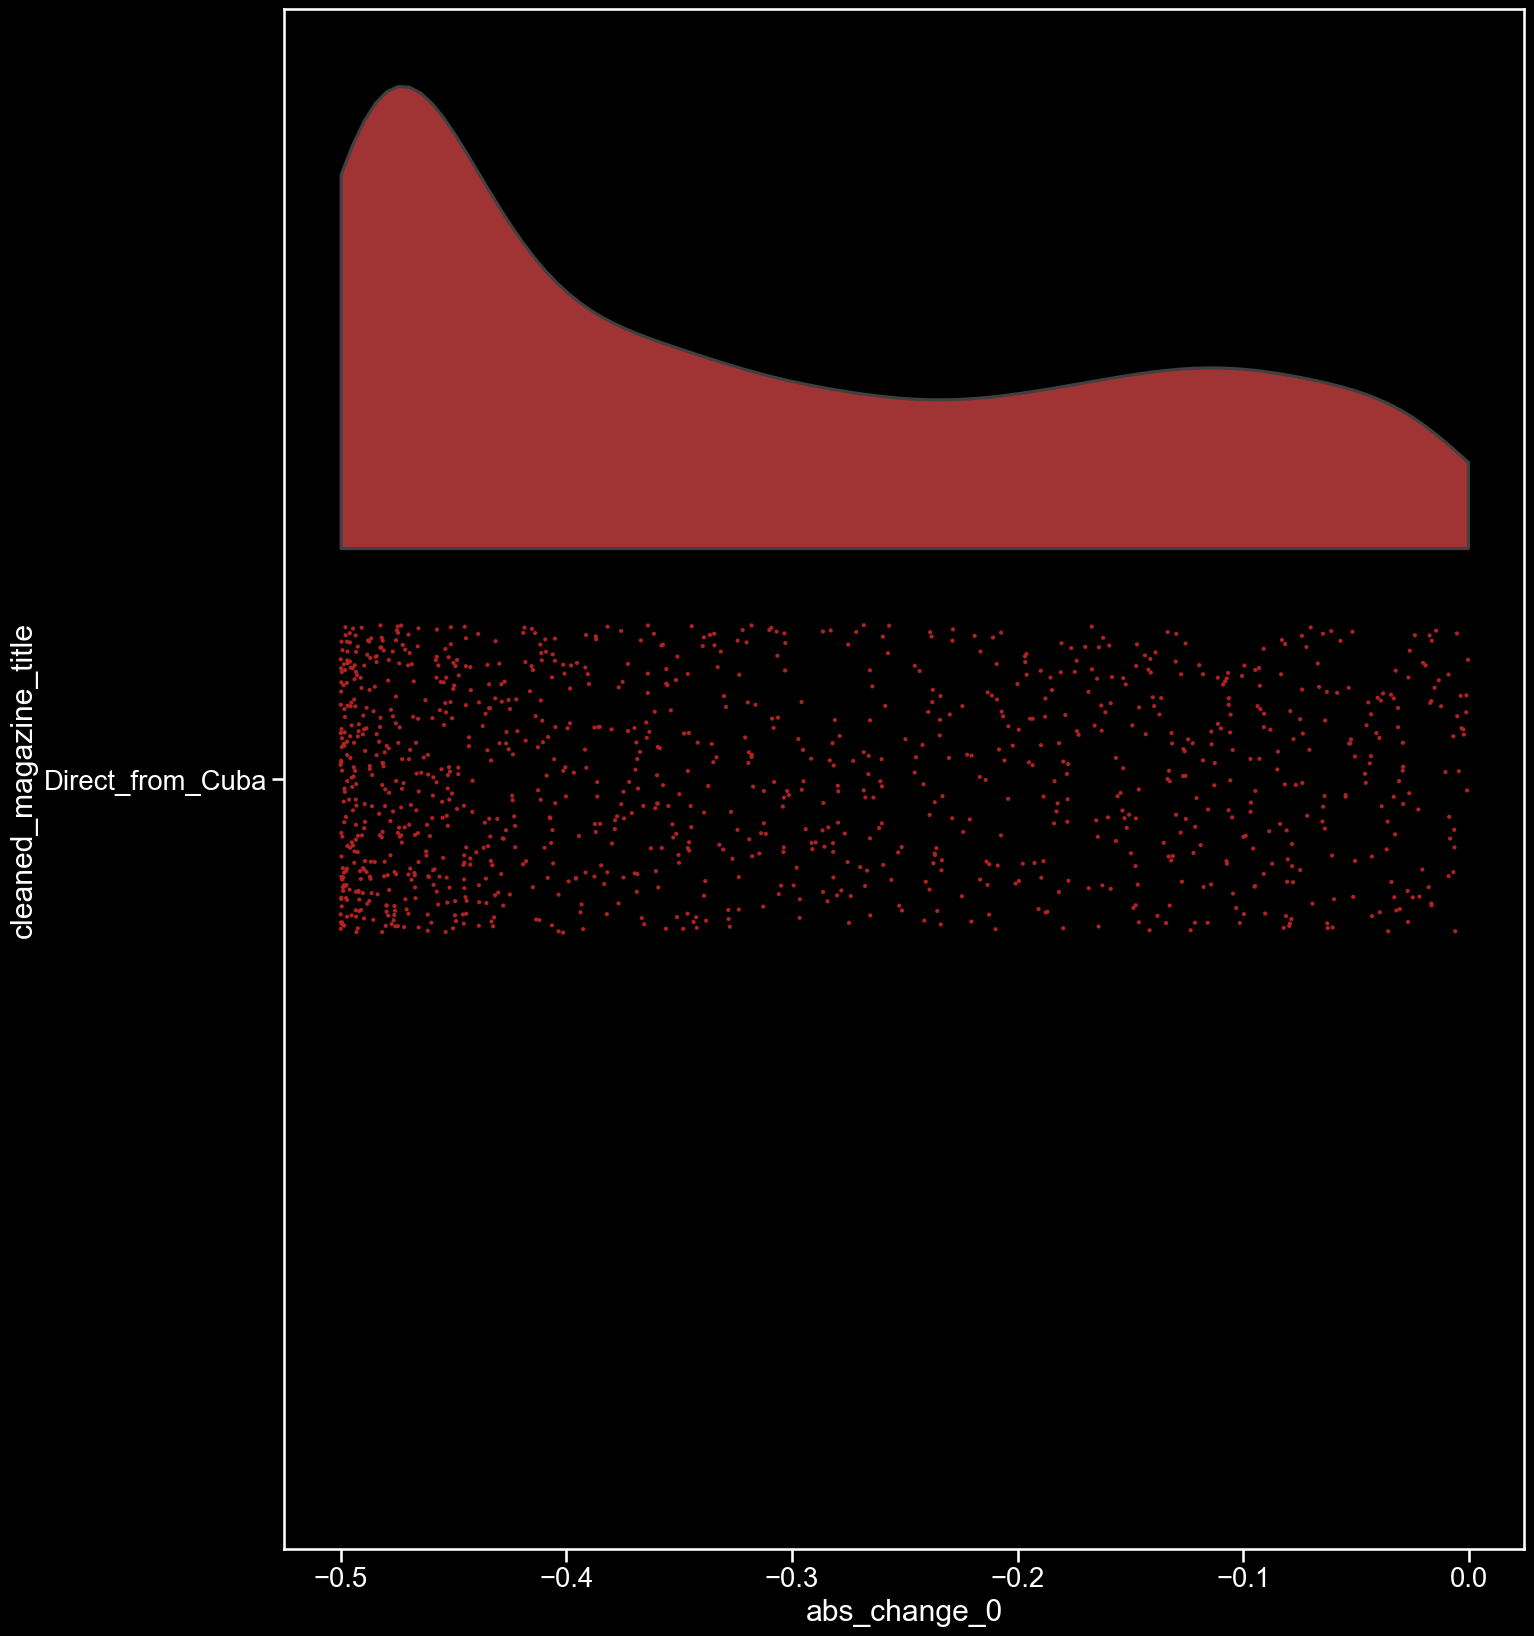

In [44]:
sns.set(style="ticks", context="talk", font_scale=1.2)
plt.style.use("dark_background")
# sns.set(rc={'figure.figsize':(8.7,8.27)}, style="whitegrid")
f, ax = plt.subplots(figsize=(16, 20))
ax = pt.half_violinplot( x = dx, y = dy, data = df, palette = pal, bw = .2, cut = 0.,scale = "area", width = .6, inner = None, order=test['cleaned_magazine_title'].unique().tolist())
ax=sns.stripplot( x = dx, y = dy, data = df, palette = pal, edgecolor = "white",size = 3, jitter = 1, zorder = 0, order=test['cleaned_magazine_title'].unique().tolist())

In [ ]:
def make_prediction_curve_grouped(classified, feature, group_name, boxplot,color_range, save, save_title):
    pl=["firebrick", "steelblue", "olive", "darkorchid", "goldenrod", "darkturquoise", "salmon", "darkslategray", "purple", "red", "green", "blue", "grey"]
    dy=feature; dx="abs_change_0"; pal = sns.color_palette(pl[color_range[0]:color_range[1]]); df=classified; ort="h"
#     .loc[classified.abs_change_0 > classified.abs_change_0.median()]

#     sns.set(style="whitegrid")
    sns.set(style="ticks", context="talk", font_scale=1.2)
    plt.style.use("dark_background")
    # sns.set(rc={'figure.figsize':(8.7,8.27)}, style="whitegrid")
    f, ax = plt.subplots(figsize=(16, 20))
    ax = pt.half_violinplot( x = dx, y = dy, data = df, palette = pal, bw = .2, cut = 0.,scale = "area", width = .6, inner = None, order=classified[feature].unique().tolist())
    ax=sns.stripplot( x = dx, y = dy, data = df, palette = pal, edgecolor = "white",size = 3, jitter = 1, zorder = 0, order=classified[feature].unique().tolist())
    
    if boxplot:
        ax=sns.boxplot(data=df, color="black",orient=ort,width=.15,x=dx,y=dy,zorder=10,showcaps=True,boxprops= {'facecolor':'none', "zorder":10},showfliers=True,whiskerprops={'linewidth':2,"zorder":10},saturation=1)

    # ax = sns.violinplot(x="prediction", y="abs_change_0", inner=None, color=".8", data=congo_classified.loc[congo_classified.abs_change_0 > 0.1])

    # #  ax = sns.violinplot(x="day", y="total_bill", data=tips,
    # # ...                     inner=None, color=".8")
    # ax = sns.stripplot(x="prediction", y="abs_change_0", data=congo_classified.loc[congo_classified.abs_change_0 > 0.1], jitter=True)

    # ax.set_size_inches(15,15)
    # axes = g.axes.flatten()
#     ax.invert_xaxis()
#     ax.yaxis.set_label_position("right")
#     ax.yaxis.tick_right()
    ax.set_title('Distribution of top predictions for {}'.format(group_name))
    ax.set_ylabel('')
    ax.set_xlabel('absolute change from decision boundary')
    # ax.figure.savefig('the_review_raincloud_plot.png')
    if save:
        ax.figure.savefig(save_title, dpi = 300)
    return ax